In [1]:
import warnings; warnings.filterwarnings("ignore") # remove scanpy warnings for the tutorial.
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import plotly.tools as tls
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import scanpy as sc
import rpy2.robjects as ro
import pandas as pd
import anndata as ad
import torch
pd.set_option('display.max_columns', None)

import decipher as dc
dc.pl.activate_journal_quality()

/bin/bash: /home/qp2134/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
run_id = 'rm_tuft_neuroendocrine_acinar_tf_cd_8k' # 'acinar_adm_earlypdac_pdac_5k'
adata_hvg = sc.read(f'data/{run_id}.h5ad')
adata_hvg.uns["decipher"]["run_id"] = run_id
genotypes = list(set(adata_hvg.obs["genotype"]))
print(genotypes)
# adata_WT = adata_hvg[adata_hvg.obs["genotype"] == "p53 F/F"]

['p53 +/+', 'p53 +/+, Kras WT', 'p53 F/F']


0.8346702923181509
0.16532970768184907


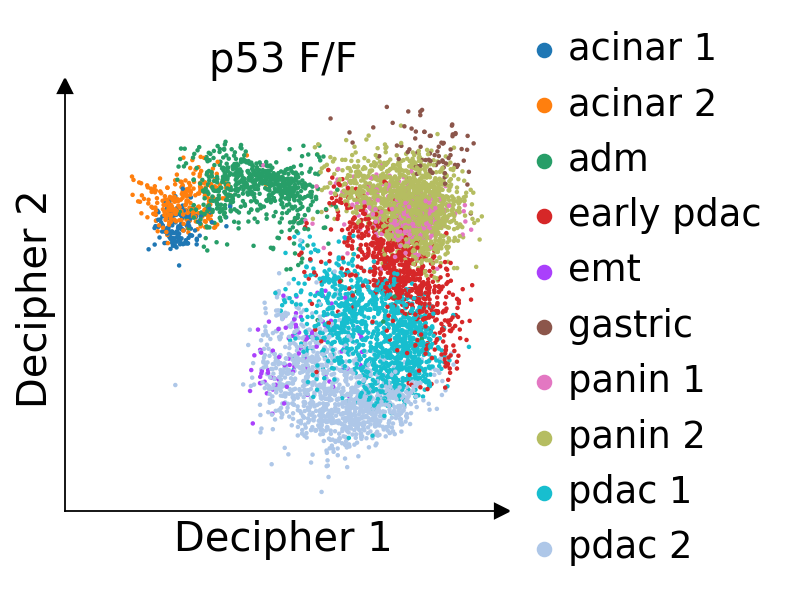

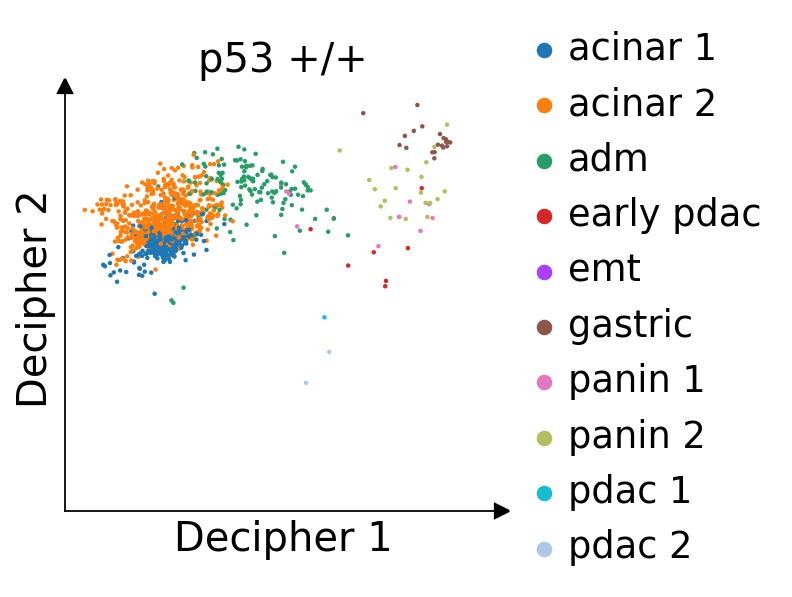

In [3]:
for genotype in ['p53 F/F', 'p53 +/+']:
    fig = dc.pl.decipher(adata_hvg, ["cell_type"], title = genotype, subset = {"genotype": genotype})

In [4]:
ax = fig.axes[0]

In [61]:
# Add G1 and G2 cells gene expressions
# gene_signature = pd.read_csv("data/gene_signatures.csv", dtype=str, keep_default_na=False, na_values=[])
# G1cells = gene_signature["G1/S"].values
# G1cells = G1cells[G1cells != '']
# for i in range(len(G1cells)):
#     G1cells[i] = G1cells[i].capitalize()

# G2cells = gene_signature["G2/M"].values
# G2cells = G2cells[G2cells != '']
# for i in range(len(G2cells)):
#     G2cells[i] = G2cells[i].capitalize()
# df = adata_hvg.to_df()
# G1cells = [col for col in G1cells if col in df.columns]
# G2cells = [col for col in G2cells if col in df.columns]
# adata_hvg.obs["G1"] = df[G1cells].mean(axis=1).values
# adata_hvg.obs["G2"] = df[G2cells].mean(axis=1).values
# adata_hvg.write_h5ad("data/rm_tuft_neuroendocrine_acinar_tf_cd_8k.h5ad")

In [ ]:
save_folder = '/home/qp2134/decipher/_decipher_models'
dim_v = 2
config = dc.tl.DecipherConfig(dim_v=dim_v)
config.initialize_from_adata(adata_hvg)

model = dc.tl._decipher.decipher.Decipher(config)
model_path = os.path.join(save_folder, run_id, "decipher_model.pt")
model.load_state_dict(torch.load(model_path))
dc.tl.decipher._decipher_to_adata(model, adata_hvg)
dc.pl.decipher(adata_hvg, basis="decipher_v", color=['G1', 'G2']) # cell_type genotype
plt.show()

RuntimeError: Error(s) in loading state_dict for Decipher:
	size mismatch for decoder_z_to_x.layers.0.weight: copying a param with shape torch.Size([22015, 10]) from checkpoint, the shape in current model is torch.Size([8000, 10]).
	size mismatch for decoder_z_to_x.layers.0.bias: copying a param with shape torch.Size([22015]) from checkpoint, the shape in current model is torch.Size([8000]).
	size mismatch for encoder_x_to_z.layers.0.weight: copying a param with shape torch.Size([128, 22015]) from checkpoint, the shape in current model is torch.Size([128, 8000]).
	size mismatch for encoder_zx_to_v.layers.0.weight: copying a param with shape torch.Size([128, 22025]) from checkpoint, the shape in current model is torch.Size([128, 8010]).

In [4]:
dc.tl.trajectories(
    adata_hvg,
    dc.tl.TConfig(name='pdac2',
        start_cluster_or_marker='acinar 1',
        end_cluster_or_marker='pdac 2',
        subset_col=None,
        subset_val=None,
        cluster_ids_list=['acinar 1', 'acinar 2', 'adm', 'pdac 1', 'pdac 2'],
        subset_percent_per_cluster=0.3,
        min_cell_per_cluster=10,),
    dc.tl.TConfig(name='gastric',
        start_cluster_or_marker='acinar 1',
        end_cluster_or_marker='gastric',
        subset_col=None,
        subset_val=None,
        cluster_ids_list=['acinar 1', 'acinar 2', 'adm', 'panin 1', 'panin 2', 'gastric'],
        subset_percent_per_cluster=0.3,
        min_cell_per_cluster=10,),
    elpi=False,
)

2024-08-20 22:10:16,421 | INFO : Trajectory pdac2: ['acinar 1', 'acinar 2', 'adm', 'pdac 1', 'pdac 2']
2024-08-20 22:10:16,422 | INFO : Added trajectory pdac2 to `adata.uns['decipher']['trajectories']`.
2024-08-20 22:10:16,446 | INFO : Trajectory gastric: ['acinar 1', 'acinar 2', 'adm', 'panin 1', 'panin 2', 'gastric']
2024-08-20 22:10:16,447 | INFO : Added trajectory gastric to `adata.uns['decipher']['trajectories']`.


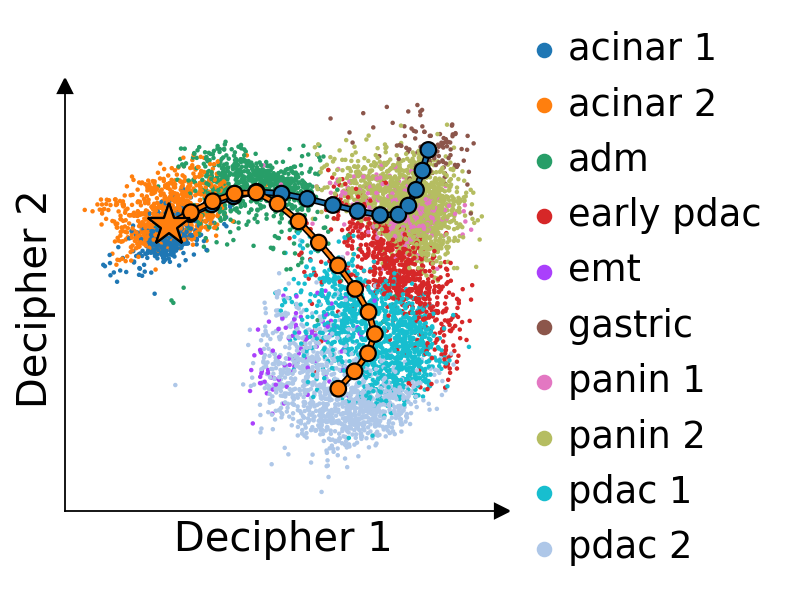

In [5]:
traj_fig = dc.pl.trajectories(adata_hvg, "cell_type")

In [6]:
dc.tl.decipher_gene_imputation(adata_hvg)

2024-08-20 22:10:21,820 | INFO : Added `.layers['imputed']`: the Decipher imputed data.


In [7]:
dc.tl.gene_patterns(adata_hvg)

In [26]:
adata_hvg.uns["decipher"]["trajectories"]['gastric'].keys()

'decipher_v'

In [23]:
adata_hvg.uns["decipher"]["gene_patterns"]['gastric'].keys()

dict_keys(['mean', 'q25', 'q75', 'mean2', 'times'])

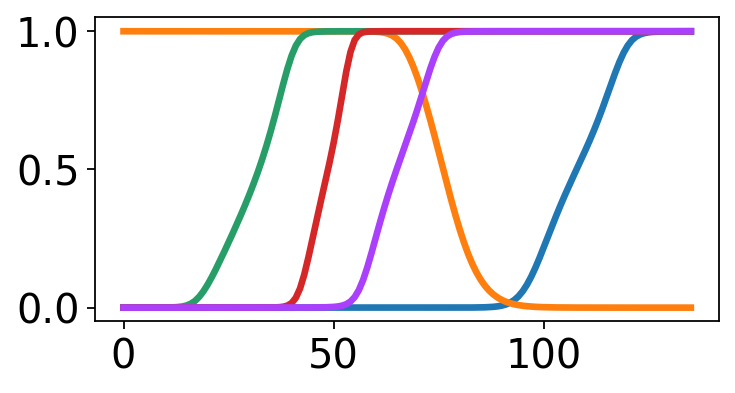

Loss: 646531.8 - Relative Error: 7.98%:  45%|████▌     | 4510/10000 [02:14<02:43, 33.55it/s]


In [9]:
training_losses = dc.tl.basis_decomposition(adata_hvg, seed=0)

In [13]:
dc.tl.disruption_scores(adata_hvg)
top_disrupted_genes = adata_hvg.var[[c for c in adata_hvg.var if "decipher_disruption" in c]].sort_values(
    "decipher_disruption_combined", ascending=False
).head(50).index.tolist()

2024-08-20 00:55:22,462 | INFO : Added `.var['decipher_disruption_shape']`: shape disruption scores
2024-08-20 00:55:22,463 | INFO : Added `.var['decipher_disruption_scale']`: scale disruption scores
2024-08-20 00:55:22,463 | INFO : Added `.var['decipher_disruption_combined']`: combined disruption scores


2024-08-20 00:55:22,471 | INFO : Added `.uns['decipher']['disruption_scores']`: disruption scores
2024-08-20 00:55:22,471 | INFO : Added `.uns['decipher']['disruption_scores_samples']`: disruption scores probabilistic samples


In [14]:
import logging
from sklearn.neighbors import KNeighborsClassifier

def _add_cell_type_band(
    adata, trajectory_name, cell_type_key, ax, palette=None, n_neighbors=50, offset=1
):
    trajectory = adata.uns["decipher"]["trajectories"][trajectory_name]
    if (
        "cell_types" not in trajectory
        or trajectory["cell_types"]["key"] != cell_type_key
        or (trajectory["cell_types"]["n_neighbors"] != n_neighbors)
    ):
        knc = KNeighborsClassifier(n_neighbors=n_neighbors)
        knc.fit(adata.obsm[trajectory["rep_key"]], adata.obs[cell_type_key])
        cell_types = knc.predict(trajectory["points"])
        trajectory["cell_types"] = {
            "key": cell_type_key,
            "n_neighbors": n_neighbors,
            "values": cell_types,
        }

    times = trajectory["times"]
    cell_types = trajectory["cell_types"]["values"]

    if palette is None:
        logging.info("No palette provided for the cell types, using default.")
        ct = np.unique(cell_types)
        palette = dict(zip(ct, sns.color_palette(n_colors=len(ct))))

    # Use the ax provided instead of the default plt
    ax.scatter(
        times,
        np.zeros(len(times)) - 0.05 * offset + 0.025,
        c=[palette[c] for c in cell_types],
        marker="s",
        s=20,
        transform=ax.get_xaxis_transform(),
        clip_on=False,
        edgecolors=None,
    )
    ax.xaxis.labelpad = 5 + 5 * offset

def gene_patterns(
    adata,
    gene_names,
    crop_to_min_length=False,
    smoothing_window=5,
    cell_type_key=None,
    time_axis = "times",
    palette=None,
    pattern_names=None,
    figsize=(30, 20),
    include_uncertainty=True,
    max_length=None,
    cell_type_band_pattern_names=None,
    nrows=5,
    ncols=4,
):
    """Plot the gene patterns over the Decipher time in a grid of subplots.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    gene_names : list of str
        The names of the genes to plot.
    crop_to_min_length : bool, default False
        Crop the plot to the minimum length of the gene patterns.
    smoothing_window : int, default 5
        The size of the window for the moving average smoothing.
    cell_type_key : str, optional
        The key of the cell type annotations in `adata.obs`. If provided, the cell types will be
        plotted as colored bands on the x-axis. See `cell_type_band_pattern_names` for more details.
    palette : dict, optional
        A dictionary mapping pattern names and cell type names to colors.
    pattern_names : str or list of str, optional
        The names of the gene patterns to plot. If None, plot all gene patterns.
    figsize : tuple of float, default (15, 10)
        The size of the figure.
    include_uncertainty : bool, default True
        Whether to include the uncertainty of the gene patterns in the plot, as a shaded area.
    max_length : int, optional
        The maximum length of the gene patterns to plot. If None, plot the full length, up to the
        minimum length of the gene patterns if `crop_to_min_length` is True.
    cell_type_band_pattern_names : str or list of str, optional
        The names of the gene patterns to use for the cell type bands. If None, use the same gene
        patterns as `pattern_names`. It is useful to use a subset of the gene patterns to avoid
        multiple bands.
    nrows : int, default 2
        Number of rows in the subplot grid.
    ncols : int, default 2
        Number of columns in the subplot grid.
    """

    # Ensure gene_names is a list
    if isinstance(gene_names, str):
        gene_names = [gene_names]

    # Create figure and axes for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case nrows * ncols > 1

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), "same") / np.convolve(np.ones_like(x), np.ones(w), "same")

    if pattern_names is None:
        pattern_names = list(adata.uns["decipher"]["gene_patterns"].keys())
    elif isinstance(pattern_names, str):
        pattern_names = [pattern_names]

    default_color_palette = sns.color_palette(n_colors=len(pattern_names))

    for i, gene_name in enumerate(gene_names):
        if i >= len(axes):
            break  # If there are more genes than subplots, exit

        gene_id = [adata.var_names.tolist().index(gene_name)]
        ax = axes[i]  # Select the appropriate subplot

        start_times = []
        end_times = []

        for j, p_name in enumerate(pattern_names):
            gene_pattern = adata.uns["decipher"]["gene_patterns"][p_name]

            gene_pattern_mean = gene_pattern["mean"][:, gene_id].mean(axis=1)
            gene_pattern_mean = moving_average(gene_pattern_mean, smoothing_window)
            gene_pattern_q25 = gene_pattern["q25"][:, gene_id].mean(axis=1)
            gene_pattern_q25 = moving_average(gene_pattern_q25, smoothing_window)
            gene_pattern_q75 = gene_pattern["q75"][:, gene_id].mean(axis=1)
            gene_pattern_q75 = moving_average(gene_pattern_q75, smoothing_window)
            times = gene_pattern[time_axis]

            times = times[:max_length]
            gene_pattern_mean = gene_pattern_mean[:max_length]
            gene_pattern_q25 = gene_pattern_q25[:max_length]
            gene_pattern_q75 = gene_pattern_q75[:max_length]

            if palette is not None and p_name in palette:
                color = palette[p_name]
            else:
                color = default_color_palette[j]

            start_times.append(times[0])
            end_times.append(times[-1])

            if include_uncertainty:
                ax.fill_between(times, gene_pattern_q25, gene_pattern_q75, color=color, alpha=0.3)
            ax.plot(times, gene_pattern_mean, label=p_name, color=color, linewidth=2)

        if cell_type_key is not None:
            if cell_type_band_pattern_names is None:
                cell_type_band_pattern_names = pattern_names
            for j, p_name in enumerate(cell_type_band_pattern_names):
                _add_cell_type_band(adata, p_name, cell_type_key, ax, palette, offset=j + 1)

        if crop_to_min_length:
            ax.set_xlim(max(start_times), min(end_times))
        else:
            ax.set_xlim(min(start_times), max(end_times))

        ax.set_xticks([])
        ax.set_xlabel("Decipher time", fontsize=10)
        ax.set_ylabel("Gene expression", fontsize=10)
        ax.set_ylim(0)
        ax.set_title(gene_name, fontsize=12)
        ax.legend(frameon=False, fontsize=8)

    # Remove unused axes if gene_names < nrows * ncols
    for i in range(len(gene_names), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    return fig

2024-08-20 00:52:09,438 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,448 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,452 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,453 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,457 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,459 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,463 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,464 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,468 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,469 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,473 | INFO : No palette provided for the cell types, using default.
2024-08-20 00:52:09,474 | INFO :

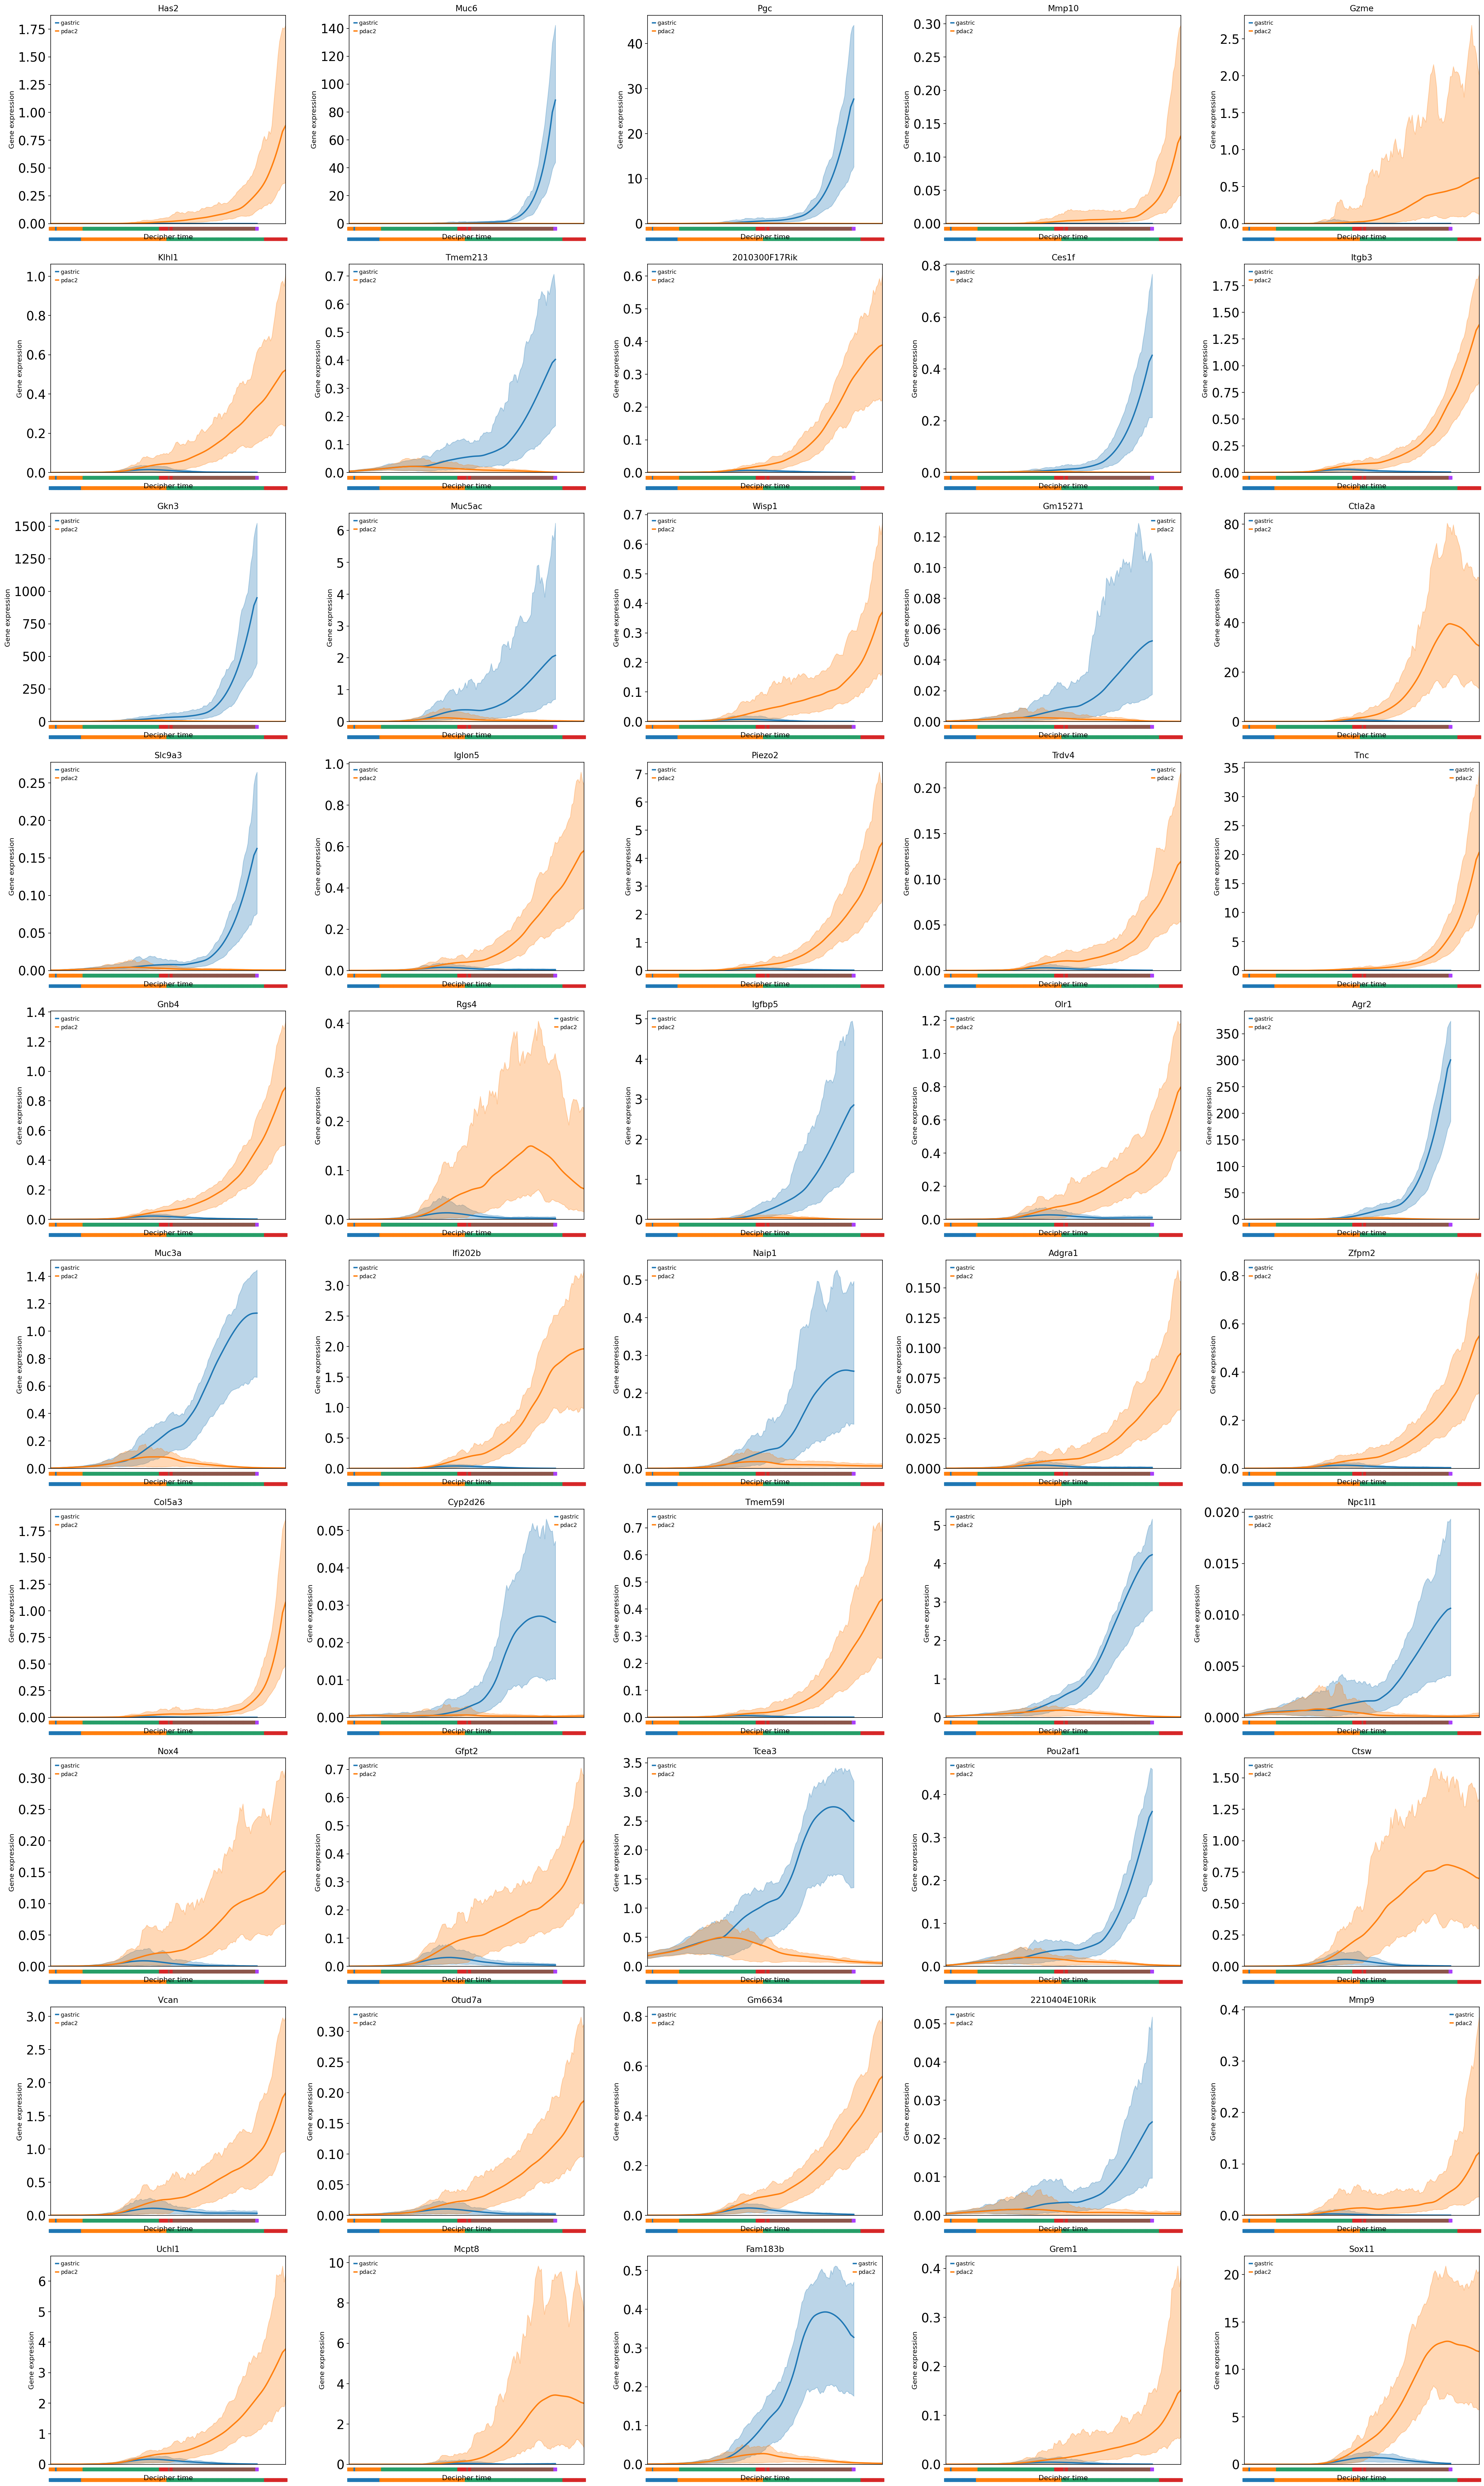

In [12]:
fig = gene_patterns(adata_hvg, top_disrupted_genes, 
                    cell_type_key="cell_type", time_axis="times", figsize=(30, 50), nrows=10, ncols=5) # ['Tff1', 'Cldn4', 'Try4']